# Cluster

Taking our clean df from 1_wrangle, checking assumptions, figuring out how many clusters to extract, and clustering on dietary patterns.


## Housekeeping

In [1]:
# If in colab, mount drive and set wd
# If local, set wd to parent of notebook
import os
import re

try:
  from google.colab import drive
  drive.mount('/content/drive')
  os.chdir('/content/drive/MyDrive/ds1_nhanes/')
except:
  from pathlib import Path
  if not re.search(r'ds1_nhanes$', str(os.getcwd())):
    os.chdir(Path(os.getcwd()).parent)

print(os.getcwd())

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1-4PHX9XhMUWpi_lTsGHtTyz6s3O0u5a2/ds1_nhanes


Pull in dataset and keep only relevant columns

In [2]:
# Utilities
import sys

# Wranling and plots
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Pull imputed dataset
full = pd.read_csv('data/clean/nhanes_2017_2023_imputed.csv', header=0, index_col=0)

# Remove columns with 'total' in name, also meat (includes other meat vars)
nhanes = full.loc[:, ~full.columns.str.contains('_total|meat', case=False)]

# Pull out just food groups
foodgroups = nhanes.loc[:, 'f_citmlb_(cup_eq)':'a_drinks_(no._of_drinks)']
print(foodgroups.info())

# break out the identifier and features
# id = nhanes.iloc[:,0]

<class 'pandas.core.frame.DataFrame'>
Index: 19386 entries, 1 to 19386
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   f_citmlb_(cup_eq)          19386 non-null  float64
 1   f_other_(cup_eq)           19386 non-null  float64
 2   f_juice_(cup_eq)           19386 non-null  float64
 3   v_drkgr_(cup_eq)           19386 non-null  float64
 4   v_redor_tomato_(cup_eq)    19386 non-null  float64
 5   v_redor_other_(cup_eq)     19386 non-null  float64
 6   v_starchy_potato_(cup_eq)  19386 non-null  float64
 7   v_starchy_other_(cup_eq)   19386 non-null  float64
 8   v_other_(cup_eq)           19386 non-null  float64
 9   v_legumes_(cup_eq)         19386 non-null  float64
 10  g_whole_(oz_eq)            19386 non-null  float64
 11  g_refined_(oz_eq)          19386 non-null  float64
 12  pf_organ_(oz_eq)           19386 non-null  float64
 13  pf_poult_(oz_eq)           19386 non-null  float64


## K-Means Clustering

[When working with distance-based algorithms, like k-Means Clustering, we must normalize the data. If we do not normalize the data, variables with different scaling will be weighted differently in the distance formula that is being optimized during training. The different FPED categories have different units, cup vs. oz, and each food may have a different range of total weight consumed.

StandardScaler is commonly used for standardization:]

### Preprocessing

Removing all totals, meat (subtotal), and v_legumes for now, just to see if it helps.

In [4]:
# Reduce to food groups, but WITHOUT v_legumes, or totals, or meat
pattern = '|'.join(['total', 'meat', 'v_legumes', 'SEQN', 'weight',])
foodgroups = foodgroups.loc[:, ~foodgroups.columns.str.contains(pattern)]


In [5]:
# import sci-kit for standardscaler
from sklearn.preprocessing import StandardScaler

# initialize the StandardScaler
scaler = StandardScaler()

# apply StandardScaler to the
foodgroups_scaled = scaler.fit_transform(foodgroups)

In [6]:
from sklearn.decomposition import PCA
pca = PCA()
foodgroups_pca = pca.fit_transform(foodgroups_scaled)

### Test Run

In [7]:
# import sci-kit for k means clustering
from sklearn.cluster import KMeans

# apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(foodgroups_pca, sample_weight=nhanes['weight_2d'])

Check out a plot with this test run:

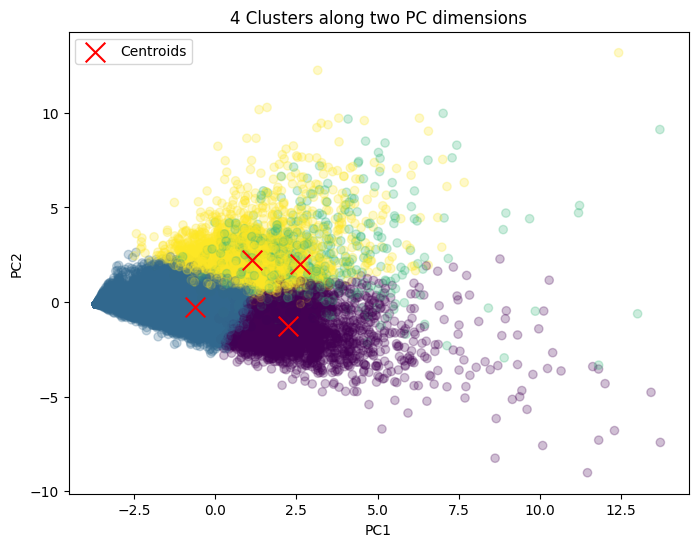

In [8]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    foodgroups_pca[:, 0],
    foodgroups_pca[:, 1],
    c=clusters,
    cmap='viridis',
    alpha=0.25
)
centers = kmeans.cluster_centers_
plt.scatter(
    centers[:, 0],
    centers[:, 1],
    c='red',
    marker='x',
    s=200,
    label='Centroids'
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("4 Clusters along two PC dimensions")
plt.legend()

# Save it
plt.savefig('outputs/checkin_2/k4_cluster.png')

plt.show()

Check it out with a 3d plot from plotly. Note that we are importing this from our very own ds1_nhanes package. See ds1_nhanes/ds1_nhanes/utils.py to see or edit the code.

In [9]:
from ds1_nhanes.utils import graph_plotly
graph_plotly(df = foodgroups_pca, labels = clusters, title = '4 K-Means Clusters over 3 PC Dimensions')

In [10]:
# Also going to collect results in a list with k = 4 to compare later
results = {}
results['kmeans_all_fped'] = clusters

### Determine optimal number of clusters

[We do not know how many clusters we should be using, the Silhoette Score and Elbow Method is commonly used to find the optimal number of clusters to ensure we are not overfitting with too many clusters or underfitting with too few.

Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

The elbow method measures how tightly points cluster around centroids using sum of squared distances (SSD), the elbow is where the SSD stops decreasing sharply.]

In [11]:
from sklearn.metrics import silhouette_score
from matplotlib.ticker import FuncFormatter

K = range(2, 7)
fits = []
elbow_score = []
silhouette_scores = []

for k in K:
    # train the model for current value of k on training data
    model = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(foodgroups_pca, sample_weight=nhanes['weight_2d'])

    # append the model to fits
    fits.append(model)

    # Append the silhouette score to scores
    silhouette_scores.append(silhouette_score(foodgroups_pca, model.labels_, metric='euclidean'))

    # Store inertia (sum of squared distances)
    elbow_score.append(model.inertia_)

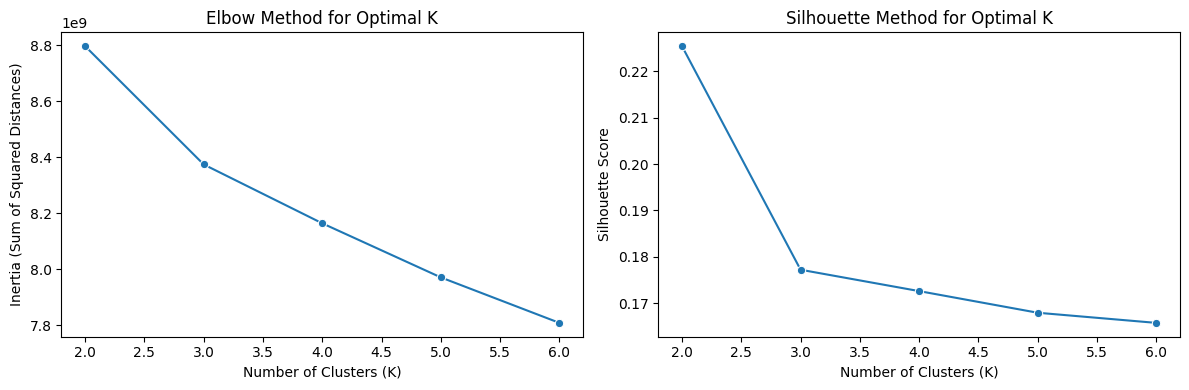

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Left plot: Elbow Method
sns.lineplot(x=K, y=elbow_score, marker="o", ax=axs[0])
axs[0].set_xlabel("Number of Clusters (K)")
axs[0].set_ylabel("Inertia (Sum of Squared Distances)")
axs[0].set_title("Elbow Method for Optimal K")

# Right plot: Silhouette Method (just an example — replace with correct data!)
sns.lineplot(x=K, y=silhouette_scores, marker="o", ax = axs[1])
axs[1].set_xlabel("Number of Clusters (K)")
axs[1].set_ylabel("Silhouette Score")
axs[1].set_title("Silhouette Method for Optimal K")

plt.tight_layout()
plt.savefig('outputs/checkin_2/elbow_silhouette.png', dpi=300)
plt.show()



Check out plots for a series of these:

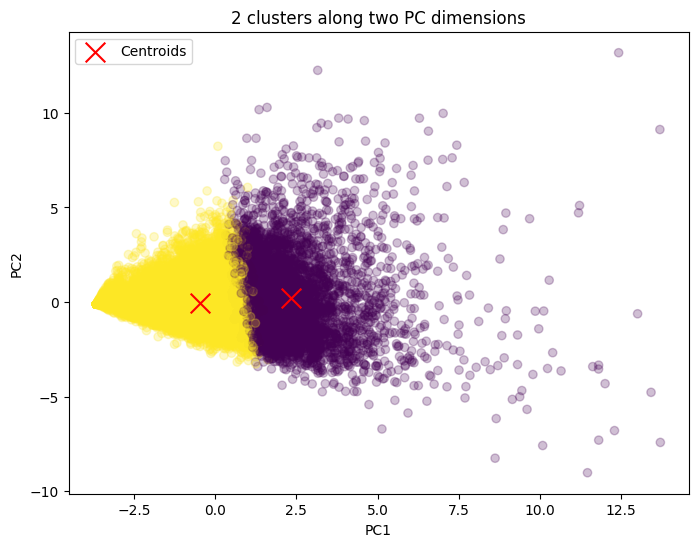

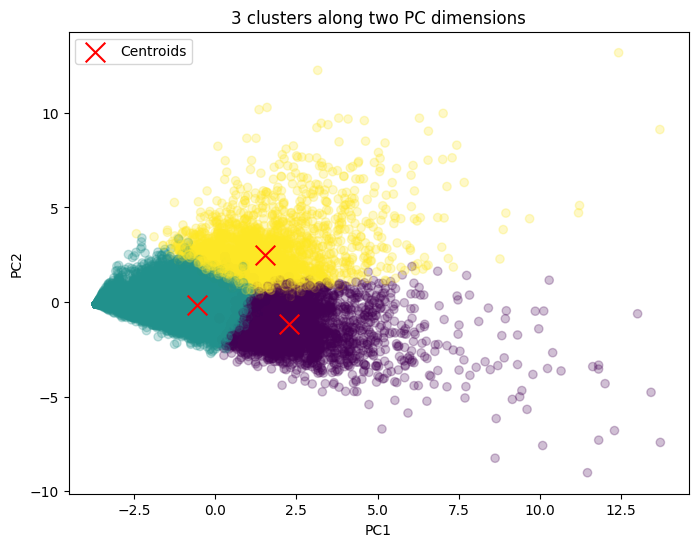

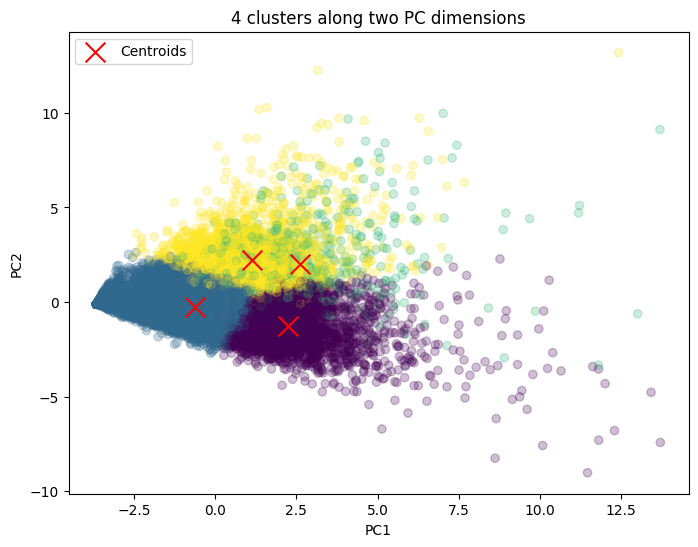

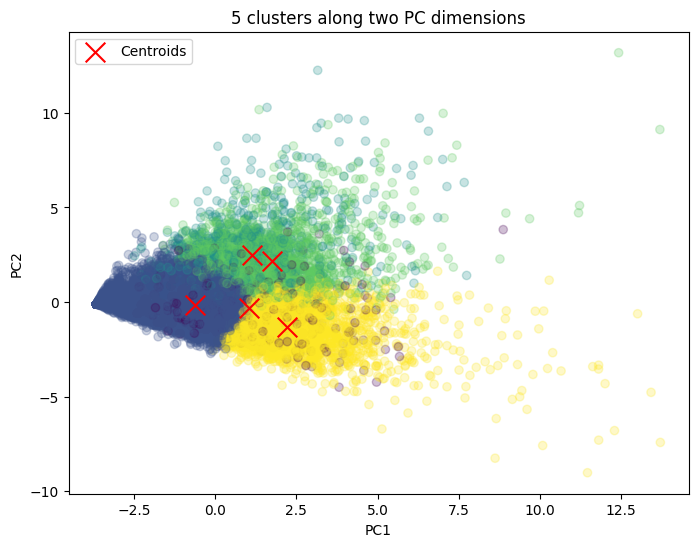

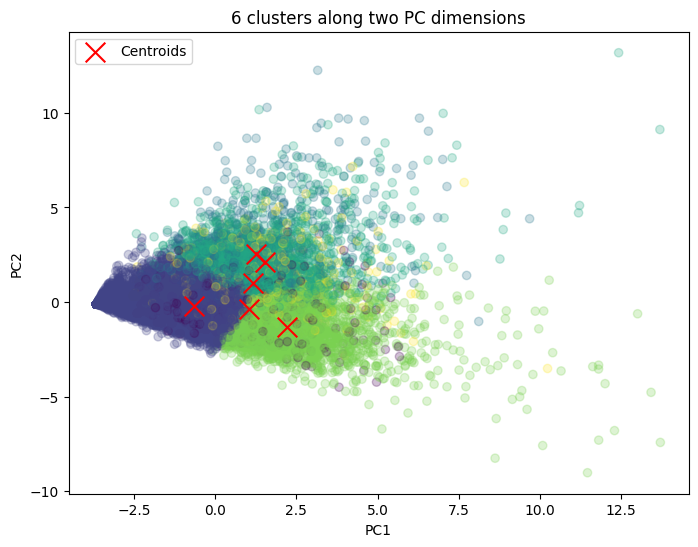

In [ ]:
for fit in fits:
    clusters = fit.fit_predict(foodgroups_pca, sample_weight=nhanes['weight_2d'])

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        foodgroups_pca[:, 0],
        foodgroups_pca[:, 1],
        c=clusters,
        cmap='viridis',
        alpha=0.25
    )
    centers = fit.cluster_centers_
    plt.scatter(
        centers[:, 0],
        centers[:, 1],
        c='red',
        marker='x',
        s=200,
        label='Centroids'
    )
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"{fit.n_clusters} clusters along two PC dimensions")
    plt.legend()
    plt.show()

Check out how many are in each group

In [ ]:
for fit in fits:
  print(pd.DataFrame(fit.labels_).value_counts())

0
1    14361
0     5025
Name: count, dtype: int64
0
1    13051
0     3734
2     2601
Name: count, dtype: int64
0
1    12540
0     3567
3     2671
2      608
Name: count, dtype: int64
0
1    12461
4     3406
3     1994
2      949
0      576
Name: count, dtype: int64
0
1    11998
4     3271
3     1924
2      860
5      778
0      555
Name: count, dtype: int64


Pretty uneven clusters here

### Split Half Reliability

Adjusted Rand Index (ARI) is a metric for reliability of cluster labels. We split dataset into two halves, pair each person from one half with a nearest neighbor in the other half, cluster each side independently, and see whether the labels match between pairs. The index ranges from -1 to 1, with 0 being random chance, and negative numbers being somehow worse than chance. Positive numbers are good, higher better. We are around 0.5, which is not the worst thing I suppose?

In [ ]:
# Loading functions from ds1_nhanes utilities
from ds1_nhanes.utils import split_half_val, iterate_val

aris = iterate_val(foodgroups_pca, k=3, n_iter=10, random_state=42)
print(aris)
print(f"Mean ARI: {round(np.mean(aris), 3)}")

[0.5792915955321541, 0.5700638108313193, 0.5188771923857486, 0.5521494399863833, 0.5717779659311344, 0.5910982127454381, 0.5472168124571972, 0.5767402883537494, 0.5774090874762285, 0.5771910675038471]
Mean ARI: 0.566


## Backup Plans

### Hierarchical

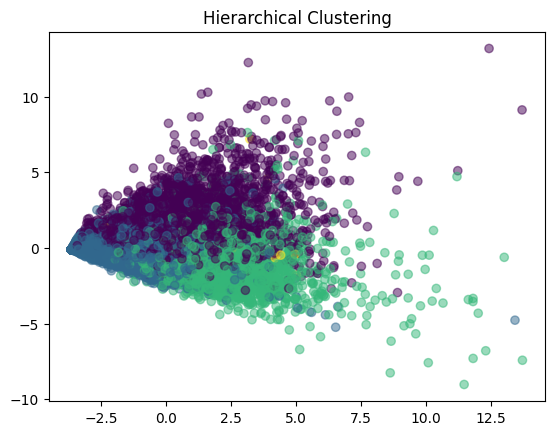

In [ ]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters = 4)
h_labels = agg.fit_predict(foodgroups_pca)

# Save it to results list
results['hierarchical'] = h_labels

# plot it
plt.scatter(foodgroups_pca[:, 0], foodgroups_pca[:, 1], c=h_labels, cmap='viridis', alpha=0.5)
plt.title("Hierarchical Clustering")
plt.show()


In [ ]:
pd.DataFrame(h_labels).value_counts()

0
1    8018
0    6707
2    4580
3      81
Name: count, dtype: int64

In [ ]:
graph_plotly(df=foodgroups_pca, labels=h_labels, title='Hierarchical Clusters')

Hierarchical figure [yoinked from here](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html)

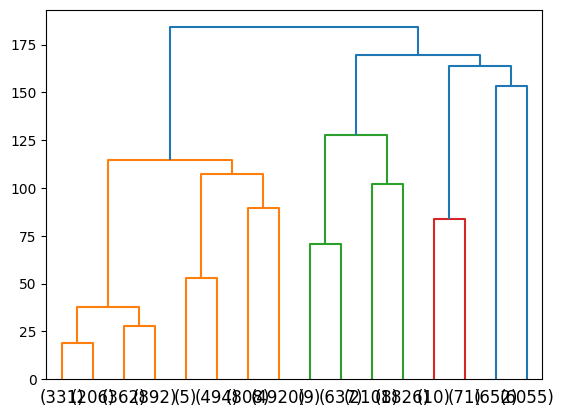

In [ ]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(foodgroups_pca)

plot_dendrogram(model, truncate_mode="level", p=3)

### *Consolidate Food Groups*

#### Wrangling

In [ ]:
full.columns

Index(['SEQN', 'weight_2d', 'grams', 'f_total_(cup_eq)', 'f_citmlb_(cup_eq)',
       'f_other_(cup_eq)', 'f_juice_(cup_eq)', 'v_total_(cup_eq)',
       'v_drkgr_(cup_eq)', 'v_redor_total_(cup_eq)', 'v_redor_tomato_(cup_eq)',
       'v_redor_other_(cup_eq)', 'v_starchy_total_(cup_eq)',
       'v_starchy_potato_(cup_eq)', 'v_starchy_other_(cup_eq)',
       'v_other_(cup_eq)', 'v_legumes_(cup_eq)', 'g_total_(oz_eq)',
       'g_whole_(oz_eq)', 'g_refined_(oz_eq)', 'pf_total_(oz_eq)',
       'pf_mps_total_(oz_eq)', 'pf_meat_(oz_eq)', 'pf_curedmeat_(oz_eq)',
       'pf_organ_(oz_eq)', 'pf_poult_(oz_eq)', 'pf_seafd_hi_(oz_eq)',
       'pf_seafd_low_(oz_eq)', 'pf_eggs_(oz_eq)', 'pf_soy_(oz_eq)',
       'pf_nutsds_(oz_eq)', 'pf_legumes_(oz_eq)', 'd_total_(cup_eq)',
       'd_milk_(cup_eq)', 'd_yogurt_(cup_eq)', 'd_cheese_(cup_eq)',
       'oils_(grams)', 'solid_fats_(grams)', 'add_sugars_(tsp_eq)',
       'a_drinks_(no._of_drinks)', 'income_ratio_qs', 'oz_pbp',
       'pf_total_calc', 'prop_pbp

Reworking the totals here. We want:
- F_TOTAL (fruits)
- V_TOTAL (veggies, excludes legumes)
- G_TOTAL (grains)
- A new variable which is PF_TOTAL (excludes legumes) + PF_LEGUMES to make it an actual PF total column
- D_TOTAL (dairy)
- OILS
- SOLID_FATS
- ADDED_SUGARS
- A_DRINKS (alcoholic drinks)? Not super sure we want this or not

In [ ]:
# Matching patterns to select vars
keep = '|'.join(['total', 'oils', 'solid', 'sugar', 'drinks', 'pf_legume'])
remove = '|'.join(['calc', 'cholesterol', 'redor', 'starchy', 'mps'])

df = full.copy()
df = df.loc[:, df.columns.str.contains(keep) & ~df.columns.str.contains(remove)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19386 entries, 1 to 19386
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   f_total_(cup_eq)          19386 non-null  float64
 1   v_total_(cup_eq)          19386 non-null  float64
 2   g_total_(oz_eq)           19386 non-null  float64
 3   pf_total_(oz_eq)          19386 non-null  float64
 4   pf_legumes_(oz_eq)        19386 non-null  float64
 5   d_total_(cup_eq)          19386 non-null  float64
 6   oils_(grams)              19386 non-null  float64
 7   solid_fats_(grams)        19386 non-null  float64
 8   add_sugars_(tsp_eq)       19386 non-null  float64
 9   a_drinks_(no._of_drinks)  19386 non-null  float64
dtypes: float64(10)
memory usage: 1.6 MB


Now make a real pf_total variable by adding pf total and pf legumes, then remove pf total and legumes

In [ ]:
df['pf_total'] = df['pf_total_(oz_eq)'] + df['pf_legumes_(oz_eq)']
df = df.drop(columns=['pf_legumes_(oz_eq)', 'pf_total_(oz_eq)'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19386 entries, 1 to 19386
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   f_total_(cup_eq)          19386 non-null  float64
 1   v_total_(cup_eq)          19386 non-null  float64
 2   g_total_(oz_eq)           19386 non-null  float64
 3   d_total_(cup_eq)          19386 non-null  float64
 4   oils_(grams)              19386 non-null  float64
 5   solid_fats_(grams)        19386 non-null  float64
 6   add_sugars_(tsp_eq)       19386 non-null  float64
 7   a_drinks_(no._of_drinks)  19386 non-null  float64
 8   pf_total                  19386 non-null  float64
dtypes: float64(9)
memory usage: 1.5 MB


In [ ]:
# df = pd.DataFrame()
# df['fruit'] = nhanes.loc[:, nhanes.columns.str.contains('^f_')].sum(axis=1)
# df['veg'] = nhanes.loc[:, nhanes.columns.str.contains('^v_')].sum(axis=1)
# df['grain'] = nhanes.loc[:, nhanes.columns.str.contains('^g_')].sum(axis=1)
# df['pf'] = nhanes.loc[:, nhanes.columns.str.contains('^pf_')].sum(axis=1)
# df['dairy'] = nhanes.loc[:, nhanes.columns.str.contains('^d_')].sum(axis=1)
# df['oil'] = nhanes.loc[:, nhanes.columns.str.contains('oils')]
# df['fat'] = nhanes.loc[:, nhanes.columns.str.contains('solid')]
# df['sugar'] = nhanes['add_sugars_(tsp_eq)']
# # df['alcohol'] = nhanes['a_drinks_(no._of_drinks)']
# df['weight_2d'] = nhanes['weight_2d']
# df.head()

Let's check correlations again before we pre-process

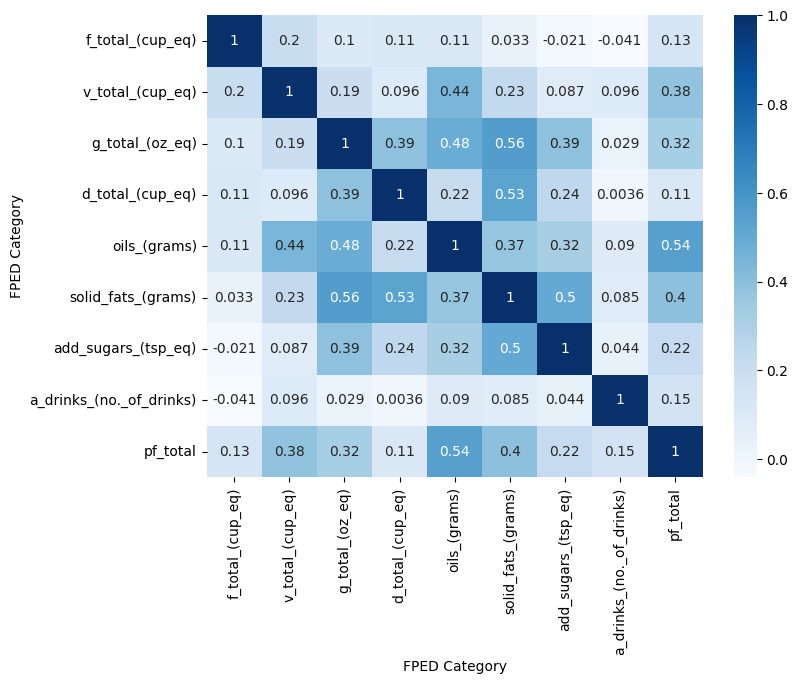

In [ ]:
cor_dat = df.copy()
matrix = cor_dat.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    matrix,
    cmap='Blues',
    annot=True
  )
plt.xlabel('FPED Category')
plt.ylabel('FPED Category')
plt.show()

#### Single Run

Now pre-process and cluster:

In [ ]:
df_scaled = StandardScaler().fit_transform(df)
df_pca = PCA().fit_transform(df_scaled)
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(df_pca, sample_weight=nhanes['weight_2d'])

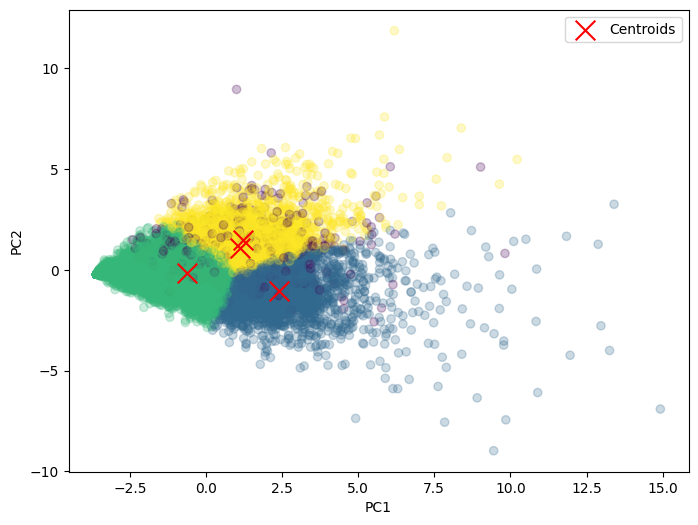

In [ ]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df_pca[:, 0],
    df_pca[:, 1],
    c=labels,
    cmap='viridis',
    alpha=0.25
)
centers = kmeans.cluster_centers_
plt.scatter(
    centers[:, 0],
    centers[:, 1],
    c='red',
    marker='x',
    s=200,
    label='Centroids'
)
plt.xlabel("PC1")
plt.ylabel("PC2")
# plt.title("")
plt.legend()

plt.savefig('outputs/checkin_3/kmeans_4_consolidated.png')
plt.show()

In [ ]:
graph_plotly(df=df_pca, labels=labels, title='K-Means Clusters on Consolidated Food Groups')

This is not half bad? Try split half reliability:

In [ ]:
# Loading functions from ds1_nhanes utilities
from ds1_nhanes.utils import split_half_val, iterate_val

aris = iterate_val(df_pca, k=4, n_iter=10, random_state=42)
print(aris)
print(f"Mean ARI: {round(np.mean(aris), 3)}")


[0.5594881295691819, 0.6782512309980615, 0.7309101789446806, 0.7058731804992657, 0.3671590538869026, 0.31618210694718557, 0.7048761328037784, 0.4680722809464483, 0.3962926470057652, 0.4644435764892998]
Mean ARI: 0.539


#### Range of Ks

In [ ]:
K = range(2, 7)
fits = []
elbow_score = []
silhouette_scores = []

for k in K:
    model = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(df_pca, sample_weight=nhanes['weight_2d'])
    fits.append(model)
    silhouette_scores.append(silhouette_score(df_pca, model.labels_, metric='euclidean'))
    elbow_score.append(model.inertia_)

# Put these in results list
results['kmeans_consolidated_fped'] = fits[2].fit_predict(df_pca, sample_weight=nhanes['weight_2d'])

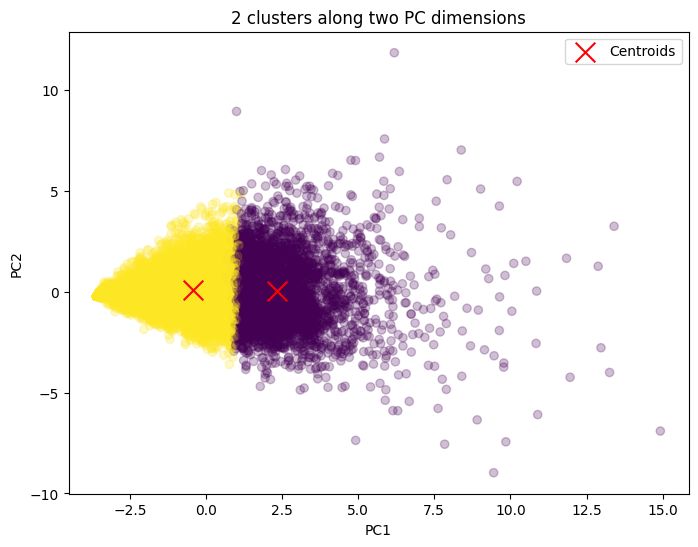

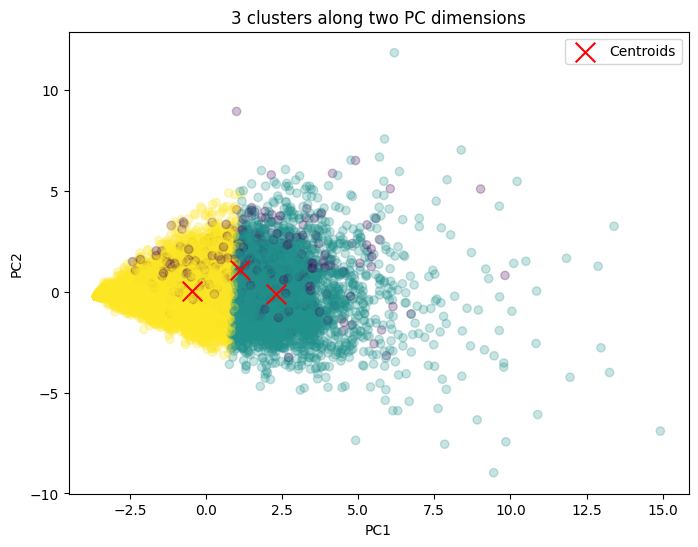

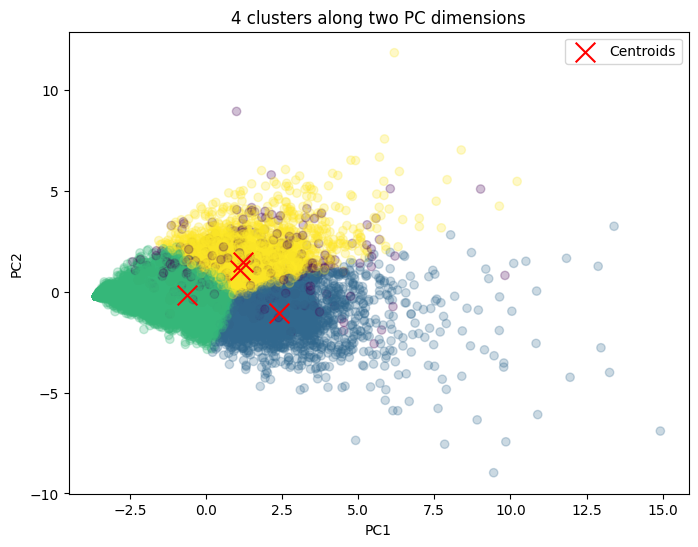

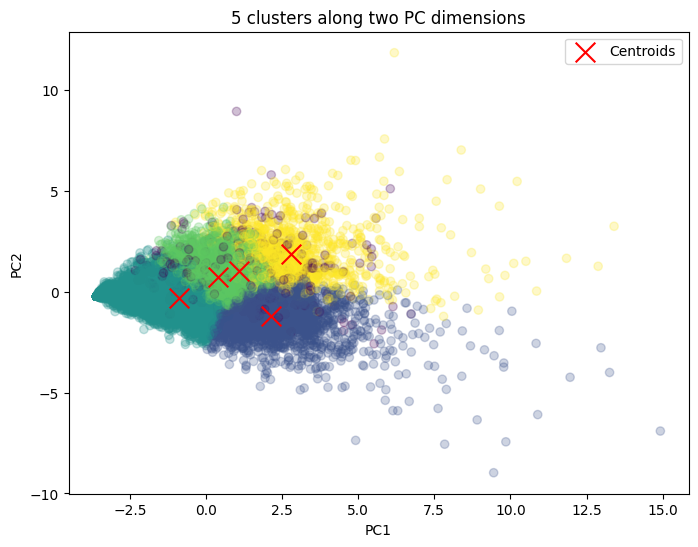

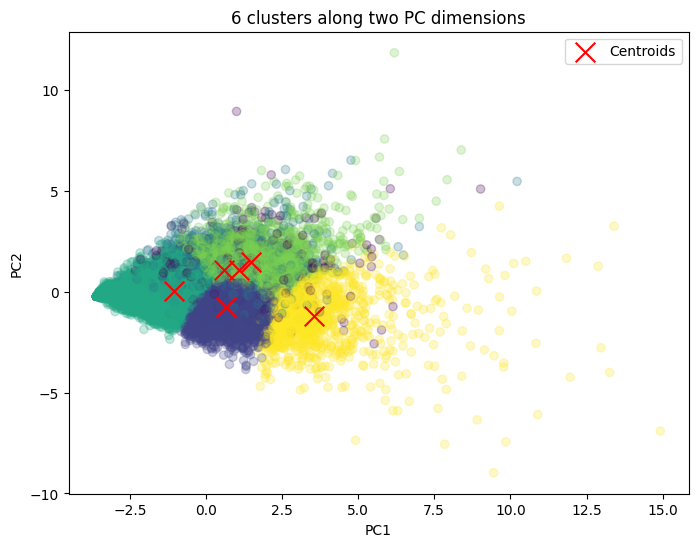

In [ ]:
for fit in fits:
    clusters = fit.fit_predict(df_pca, sample_weight=nhanes['weight_2d'])

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        df_pca[:, 0],
        df_pca[:, 1],
        c=clusters,
        cmap='viridis',
        alpha=0.25
    )
    centers = fit.cluster_centers_
    plt.scatter(
        centers[:, 0],
        centers[:, 1],
        c='red',
        marker='x',
        s=200,
        label='Centroids'
    )
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"{fit.n_clusters} clusters along two PC dimensions")
    plt.legend()
    plt.show()

Plot elbow and silhouette scores

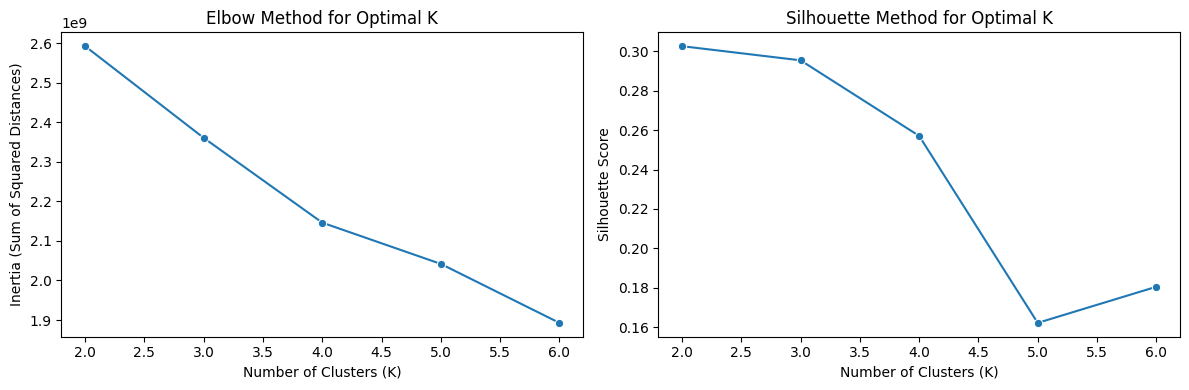

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Left plot: Elbow Method
sns.lineplot(x=K, y=elbow_score, marker="o", ax=axs[0])
axs[0].set_xlabel("Number of Clusters (K)")
axs[0].set_ylabel("Inertia (Sum of Squared Distances)")
axs[0].set_title("Elbow Method for Optimal K")

# Silhouette scores
sns.lineplot(x=K, y=silhouette_scores, marker="o", ax = axs[1])
axs[1].set_xlabel("Number of Clusters (K)")
axs[1].set_ylabel("Silhouette Score")
axs[1].set_title("Silhouette Method for Optimal K")

plt.tight_layout()
plt.savefig('outputs/checkin_3/elbow_silhouette.png', dpi=300)
plt.show()

This is actually showing some slight evidence for 4 clusters in the elbow, silhouette just keeps going down though. Save it:

In [ ]:
clusters = fits[2].fit_predict(df_pca, sample_weight=nhanes['weight_2d'])
full['cluster'] = clusters
full.to_csv('data/clean/nhanes_2017_2023_clustered.csv', index=False)

### Density Based Spatial Clustering of Applications with Noise (DBSCAN)


In [ ]:
## Setting up environment
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

Number of columns: 9
Number of rows: 19386


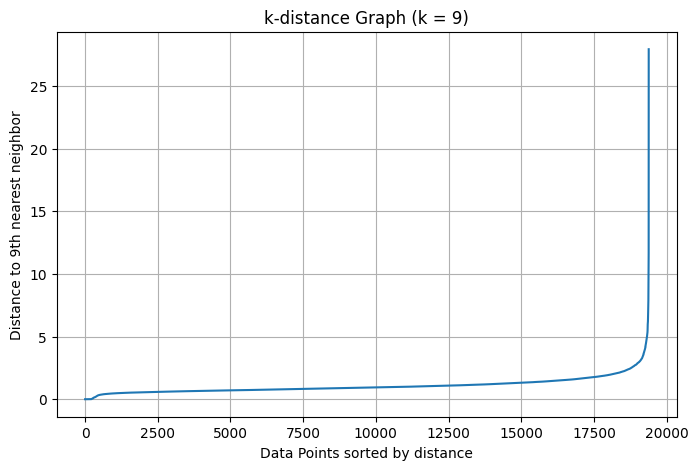

In [ ]:
# Choose k equal to min_samples (e.g., 9 if you have 8 dimensions)
num_columns = df_scaled.shape[1]
k = num_columns
rows = df_scaled.shape[0]
print(f"Number of columns: {num_columns}")
print(f"Number of rows: {rows}")


neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(df_scaled)
distances, indices = neighbors_fit.kneighbors(df_scaled)

# Sort the distances to the k-th nearest neighbor
k_distances = np.sort(distances[:, k-1])

# Plot the sorted distances
plt.figure(figsize=(8, 5))
plt.plot(k_distances)
plt.xlabel("Data Points sorted by distance")
plt.ylabel(f"Distance to {k}th nearest neighbor")
plt.title(f"k-distance Graph (k = {k})")
plt.grid(True)
plt.show()

In [ ]:
db = DBSCAN(eps=2, min_samples=9).fit(df_scaled)
labels = db.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Clusters: {n_clusters}, Noise points: {(labels == -1).sum()}")



Clusters: 1, Noise points: 689


Yikes, that did not work at all..... I am going to try a few more eps values


In [ ]:
eps_values = [0.5, 0.8, 1.0, 1.2, 1.5]
for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=9).fit(df_scaled)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    print(f"eps={eps}: clusters={n_clusters}, noise={n_noise}")


eps=0.5: clusters=8, noise=17347
eps=0.8: clusters=4, noise=9754
eps=1.0: clusters=6, noise=5982
eps=1.2: clusters=1, noise=3709
eps=1.5: clusters=1, noise=1865


Maybe.. maybe could consider an eps of 1.2 but ~26% of the data would not be included and considered noise. Would not recommend we move forward with DBSCAN. There is a saying that the rich get richer, and this happens with DBSCAN.

### Spectral Cluster

Something is clearly afoot here. For starters, running it on the foodgroups_pca data didn't finish after 10 minutes or so, so I gave up on it. The two runs below are with the reduced df_pca data, aggregated by food group. I ran it assigning labels with kmeans and also with discretize, which should be more robust to initialization. But there is obviously something wrong here. We could try messing around with gamma, affinity, n neighbors, eigen_tol, etc.

Also, this ran okay locally, but Colab runs out of RAM and crashes. So that's not ideal. Commenting these out for now.

In [ ]:
# from sklearn.cluster import SpectralClustering
# spectral_cluster = SpectralClustering(
#     n_clusters=3,
#     assign_labels='kmeans',
#     random_state=42
# ).fit(df_pca)

In [ ]:
# from ds1_nhanes.utils import graph_plotly
# graph_plotly(df = df_pca, labels = spectral_cluster.labels_, title = 'Spectral Clusters')

Okay this does not look ideal. Let's try discretize

In [ ]:
# from sklearn.cluster import SpectralClustering
# spectral_cluster = SpectralClustering(
#     n_clusters=3,
#     assign_labels='discretize',
#     random_state=42
# ).fit(df_pca)

In [ ]:
# from ds1_nhanes.utils import graph_plotly
# graph_plotly(df = df_pca, labels = spectral_cluster.labels_, title = 'Spectral Clusters')

### Gaussian Mixture

Trying Gaussian mixture with 2 through 6 components

In [ ]:
from sklearn.mixture import GaussianMixture
import numpy as np

gm_fits = []
gm_labels = []

for i in np.arange(2, 7):
    fit = GaussianMixture(n_components=i, random_state=42).fit(foodgroups_pca)
    label = fit.predict(foodgroups_pca)
    gm_fits.append(fit)
    gm_labels.append(label)

Plot them

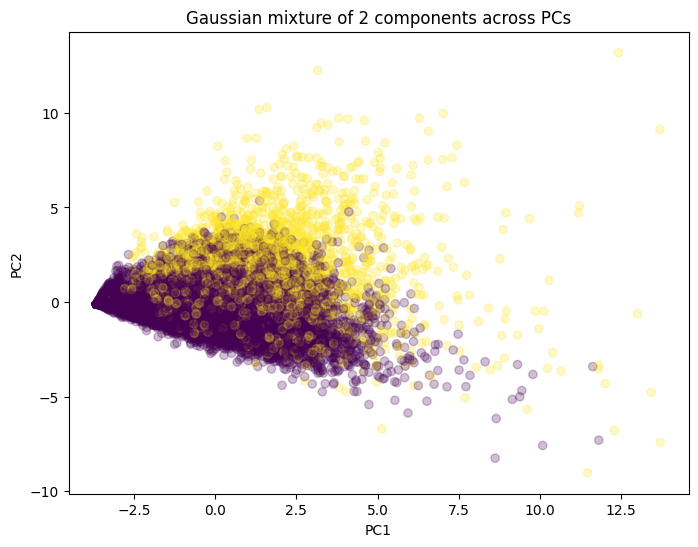

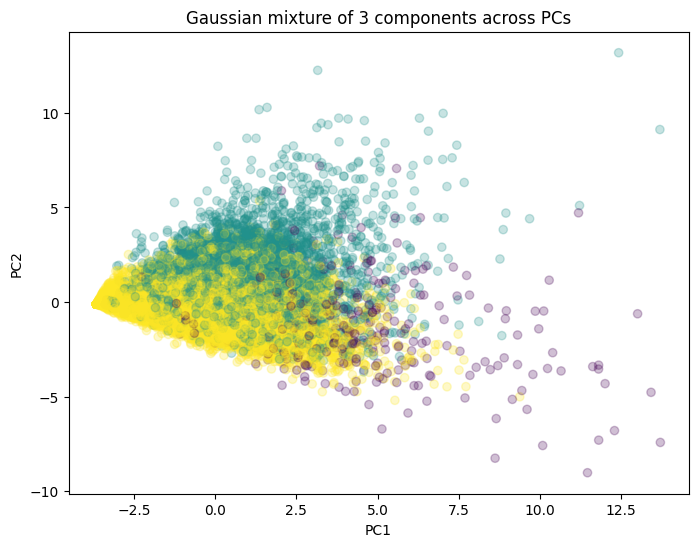

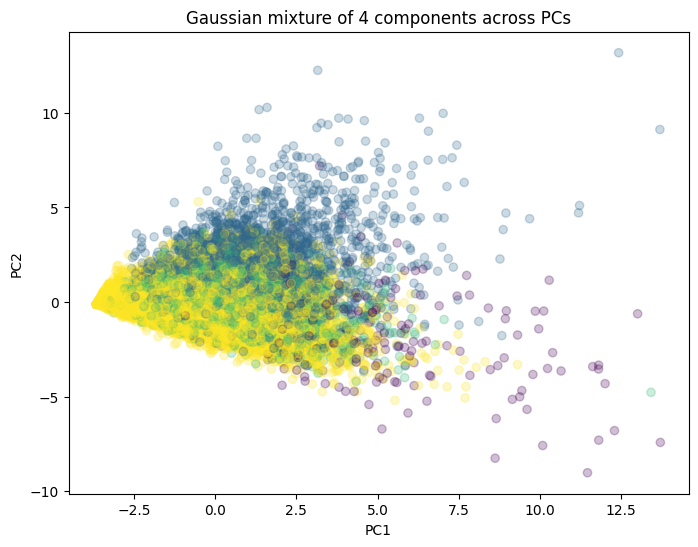

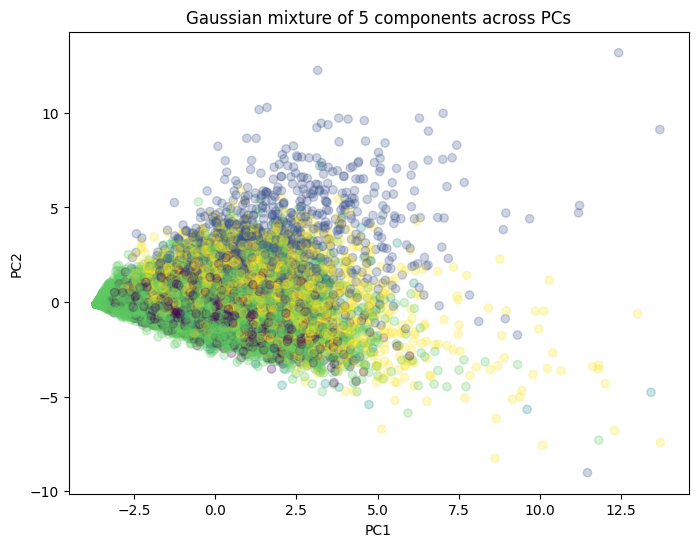

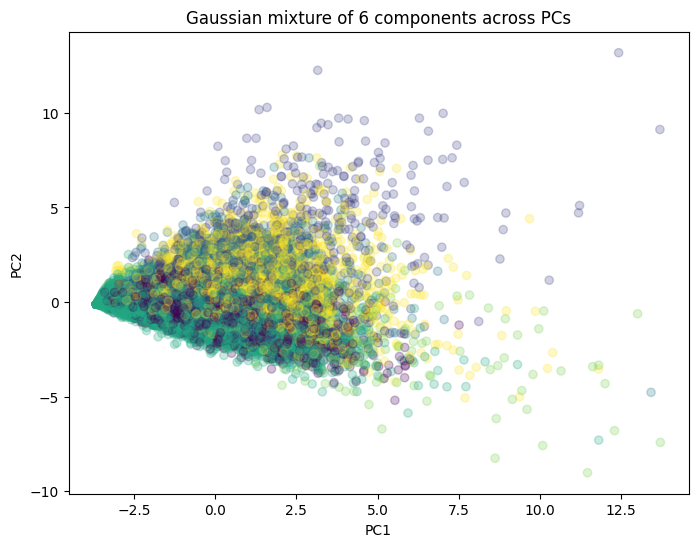

In [ ]:
for i in np.arange(2, 7):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        foodgroups_pca[:, 0],
        foodgroups_pca[:, 1],
        c=gm_labels[i - 2],
        cmap='viridis',
        alpha=0.25
    )
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"Gaussian mixture of {i} components across PCs")
    plt.show()

Check group sizes

In [ ]:
for label in gm_labels:
    print(pd.DataFrame(label).value_counts())

0
0    15292
1     4094
Name: count, dtype: int64
0
2    12784
1     5981
0      621
Name: count, dtype: int64
0
3    11768
2     4160
1     3030
0      428
Name: count, dtype: int64
0
3    9811
0    3954
4    3851
1    1488
2     282
Name: count, dtype: int64
0
3    7286
0    4994
5    3786
2    2046
1     933
4     341
Name: count, dtype: int64


Pretty uneven, similar to k means

In [ ]:
graph_plotly(df=foodgroups_pca, labels=gm_labels[1], title='Gaussian Mixture')


Check AIC and BIC curves. Lower numbers are better in each case, only interpreted relative to other values.

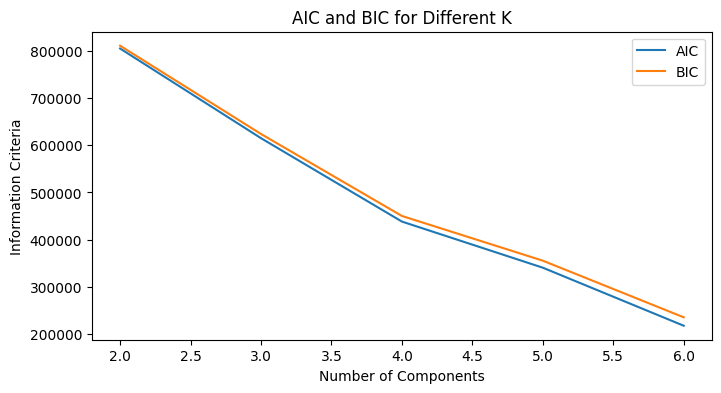

In [ ]:
AIC = [fit.aic(foodgroups_pca) for fit in gm_fits]
BIC = [fit.bic(foodgroups_pca) for fit in gm_fits]

plt.figure(figsize=(8, 4))
plt.plot(np.arange(2, 7), AIC, label='AIC')
plt.plot(np.arange(2, 7), BIC, label='BIC')
plt.xlabel("Number of Components")
plt.ylabel("Information Criteria")
plt.title("AIC and BIC for Different K")
plt.legend()
plt.show()

In [ ]:
# Put into results list
results['gaussian'] = gm_labels[2]

### t-SNE

Try visualizing same plots with t-distributed Stoachastic Neighbor Embedding.

What does it do? "t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results."

In other words, I have no idea. But it is just a way to visualize clusters, not a clustering method in itself.

Note - this takes about 8 minutes to run, so I am commenting it out so we don't run it accidentally.

In [ ]:
# from sklearn.manifold import TSNE

# KMeans
# kmeans = KMeans(n_clusters=3, random_state=42)
# labels = kmeans.fit_predict(foodgroups_pca)

# # fit TSNE
# tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
# foodgroups_tsne = tsne.fit_transform(foodgroups_pca)

# plt.figure(figsize=(8, 6))
# plt.scatter(
#     foodgroups_tsne[:, 0],
#     foodgroups_tsne[:, 1],
#     c=labels,
#     cmap='tab10',
#     alpha=0.5
# )
# plt.title("KMeans Clusters Visualized with t-SNE")
# plt.xlabel("t-SNE Component 1")
# plt.ylabel("t-SNE Component 2")
# plt.show()

## Pull out SEQNs and cluster labels

This might

In [ ]:
cluster_bm = pd.read_csv('data/clean/nhanes_2017_2023_clustered.csv')

cluster_bm.head()

cluster_bm['cluster'].value_counts()

seqn_cluster=cluster_bm[['SEQN','cluster']]

seqn_cluster.head()



SEQN  cluster
0  109263        2
1  109264        2
2  109265        2
3  109266        2
4  109269        2

In [ ]:
# Save seqn_clusters to merge w/ biomarkers

seqn_cluster.to_csv('data/clean/seqn_cluster.csv', index=False)

## Compare Models

Various other metrics from permetrics library. More info [here](https://permetrics.readthedocs.io/en/stable/pages/clustering.html). Many of them sound pretty much the same. And they are. Just slight variations on within cluster and between cluster distances.

- Dunn: Measure of distance between points in same cluster (intra cluster distance) compared to distance between points in different clusters (inter cluster distance). Larger values better, range from 0 to infinity.
- Beale Index: Within cluster sum of squares and between cluster sum of squares. Low values better, range 0 to inf.
- Hartigan: Measures sum of squares of distances between points within cluster to sum of squares of distances between data points and respective cluster centroids. Larger values better, range from 0 to infinity.
- RSI: Variance in data explained by cluster solution. Larger values better, range from -inf to 1, with 1 being perfect.

Comparing cluster metrics for:

- Kmeans, k = 4, all FPED vars
- Kmeans, k = 4, consolidated FPED vars
- Gaussian mixture, k = 4
- Hierarchical, k = 4

In [ ]:
if 'google.colab' in sys.modules:
  !pip install permetrics
from permetrics import ClusteringMetric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.1 MB/s eta 0:00:00


In [ ]:
results_list = []

for name, labels in results.items():
    cm = ClusteringMetric(X=foodgroups_pca, y_pred=labels)
    result_dict = {
        "Method": name,
        "Dunn (larger)": round(cm.dunn_index(), 3),
        "Beale (smaller)": round(cm.beale_index(), 3),
        "Hartigan (larger)": round(cm.hartigan_index(), 3),
        "RSI (larger)": round(cm.RSI(), 3)
    }
    results_list.append(result_dict)

df_results = pd.DataFrame(results_list)
df_results.head()


Method  Dunn (larger)  Beale (smaller)  \
0           kmeans_all_fped          0.040            1.795   
1              hierarchical          0.025            0.415   
2  kmeans_consolidated_fped          0.040            2.181   
3                  gaussian          0.029            3.151   

   Hartigan (larger)  RSI (larger)  
0              2.796        -4.452  
1              2.819        -5.252  
2              2.765        -3.912  
3              3.589        -6.778

After fixing error in wrangle script:
- Kmeans all fped: 1st (tie), 3rd, 2nd, 2nd (and ARI is 0.566)
- Kierarchical: 4th, 1st, 2nd, 3rd
- Kmeans consolidated: 1st (tie), 3rd, 4th, 1st (and ARI is 0.539)
- Gaussian: 4th, 4th, 1st, 4th

Let's clean up this table to put it in the paper:

In [ ]:
tab = df_results.copy()

# Remove the larger smaller note
tab.columns = tab.columns \
  .str.replace(' \(larger\)| \(smaller\)', '', regex=True)

# Clean up method column
tab['Method'] = tab['Method'].str.replace('_', ' ') \
  .str.title().str.replace('Fped', 'FPED').str.replace('Consolidated', 'Cons.')

# Sort by Method column
tab.sort_values('Method', inplace=True)
print(tab)

# Save to latex
tab.to_latex(
    'outputs/checkin_3/cluster_metrics.tex',
    index=False,
    label='tab:cluster_metrics',
    position='h',
    float_format="%.3f",
    caption='Cluster validation metrics for a series of clustering methods'
)

              Method   Dunn  Beale  Hartigan    RSI
3           Gaussian  0.029  3.151     3.589 -6.778
1       Hierarchical  0.025  0.415     2.819 -5.252
0    Kmeans All FPED  0.040  1.795     2.796 -4.452
2  Kmeans Cons. FPED  0.040  2.181     2.765 -3.912
